In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

In [104]:
# symbols = 'BTC'.split(',')
symbols = 'ETH'.split(',')
# symbols = 'BNB'.split(',')
# symbols = 'ATOM'.split(',')
# symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True, horizon=4)
# df.to_pickle('/tmp/df_horizon4_btc.pkl')
df.to_pickle('/tmp/df_horizon4_eth.pkl')
# df.to_pickle('/tmp/df_horizon4_bnb.pkl')
# df.to_pickle('/tmp/df_horizon4_atom.pkl')
display(df)

,,op,hi,lo,cl,execution_start_at,ret
timestamp,symbol,,,,,,
2019-11-12 00:00:00+00:00,ATOM,4.309719,4.332907,4.303773,4.316895,2019-11-12 01:00:00+00:00,-0.006058
2019-11-12 01:00:00+00:00,ATOM,4.318080,4.318080,4.235548,4.241362,2019-11-12 02:00:00+00:00,0.003994
2019-11-12 02:00:00+00:00,ATOM,4.243636,4.244790,4.196333,4.229328,2019-11-12 03:00:00+00:00,0.004562
2019-11-12 03:00:00+00:00,ATOM,4.229607,4.229607,4.171447,4.176481,2019-11-12 04:00:00+00:00,-0.005988
2019-11-12 04:00:00+00:00,ATOM,4.175684,4.235937,4.173550,4.225052,2019-11-12 05:00:00+00:00,-0.017721
...,...,...,...,...,...,...,...
2022-09-07 07:00:00+00:00,ATOM,11.814714,11.868940,11.774001,11.847274,2022-09-07 08:00:00+00:00,-0.010747
2022-09-07 08:00:00+00:00,ATOM,11.846357,11.959386,11.836612,11.946423,2022-09-07 09:00:00+00:00,NaN
2022-09-07 09:00:00+00:00,ATOM,11.941579,11.974788,11.885953,11.897659,2022-09-07 10:00:00+00:00,NaN


In [14]:

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor

class ExampleModelRank:
    def __init__(self):
        # self._model = Ridge(fit_intercept=False, alpha=1e5)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        self._model = lgb.LGBMRegressor(
            # n_estimators=1000,
            # learning_rate=0.001,
            extra_trees=True,
            # colsample_bytree=0.2,
            random_state=1,
            n_jobs=-1,
        )
        # self._model = lgb.LGBMClassifier(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        self._model = BaggingRegressor(
            self._model,
            # n_estimators=40,
            # max_samples=0.9,
            # bootstrap=False,
            random_state=1
        )
        
        self.max_data_sec = 14 * 24 * 60 * 60 # for predict script
        self.horizon = 4

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        # df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-4) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script 
        # return self._model.fit(df[features], df['ret_train'])
        return self._model.fit(df[features], np.sign(df['ret_train']), sample_weight=np.abs(df['ret_train']))
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        # df['position'] = 0.0
        # for m in self._model.estimators_:
        #     y_pred = m.predict(df[features])
        #     df['position'] = np.sign(y_pred)
        # df['position'] /= len(self._model.estimators_)
        
        y_pred = self._model.predict(df[features])
        df['position'] = np.sign(y_pred)
        # df['position'] = y_pred
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.2))
        
        # normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):        
        df = df.copy()
        
        df['ln_hilo'] = 0.5 * (np.log(df['hi']) + np.log(df['lo']))
        df['ln_hilocl'] = (np.log(df['hi']) + np.log(df['lo']) + np.log(df['cl'])) / 3
        
        df['ln_cl'] = np.log(df['cl'])
        df['ln_cl_diff'] = (df['ln_cl'] - df.groupby('symbol')['ln_cl'].shift(1)).fillna(0)
        df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
        
        for i in [1, 2, 4, 8, 24, 48, 72, 168]:
            df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)
        for i in [2, 4, 8, 24, 48, 72, 168]:
        # for i in [3, 5, 11, 29, 53, 73]:
        # for i in [2, 4, 8, 24, 48, 72] + [3, 5, 11, 29, 53, 73]:
            df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: signed_rsi_sma(x, timeperiod=i))
            df['feature_std_{}'.format(i)] = df.groupby('symbol')['ln_cl'].transform(lambda x: x.rolling(i, 1).std()).fillna(0)
            # df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))

        # symbol_count = df.reset_index()['symbol'].unique().size
    
        # for col in get_feature_columns(df):
        #     df[col + '_rr'] = df.groupby('symbol')[col].transform(lambda x: x.rolling(1000, 1).rank(pct=True) - 0.5)
        # #     # df[col + '_rank'] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
        # #     # df[col] = df[col].rolling(symbol_count * 24, 1).rank(pct=True) - 0.5
        # #     # df[col] = (df[col] - df.groupby('timestamp')[col].transform('mean')) / (1e-37 + df.groupby('timestamp')[col].transform('std').fillna(0))
        #     df = df.drop(columns=col)
            
        return df

def calc_pos(x, th):
    pos = x.copy() * 0.0
    p = 0.0
    for i in range(x.shape[0]):
        if x.iloc[i] > th:
            p = 1.0
        elif x.iloc[i] < -th:
            p = -1.0
        pos.iloc[i] = p
    return pos

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return v.rolling(timeperiod, 1).mean() / (1e-37 + v.abs().rolling(timeperiod, 1).mean())

return without cost statistics
mean 0.0008594903100355718
std 0.01906835542656065
sharpe 0.0450741708348048
max drawdown 0.32193348100616737
return with cost statistics
mean 0.0004866439770902919
std 0.01906736496530617
sharpe 0.025522350779762174
max drawdown 0.3227334810061674


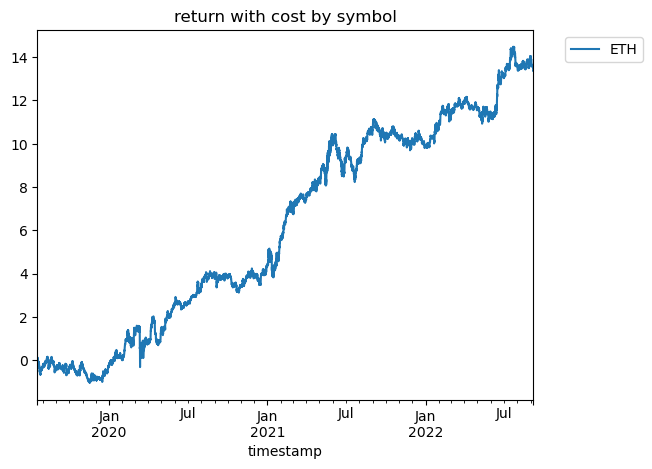

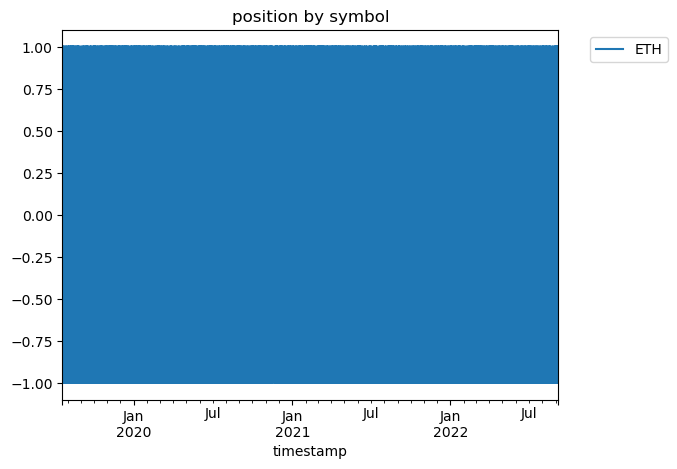

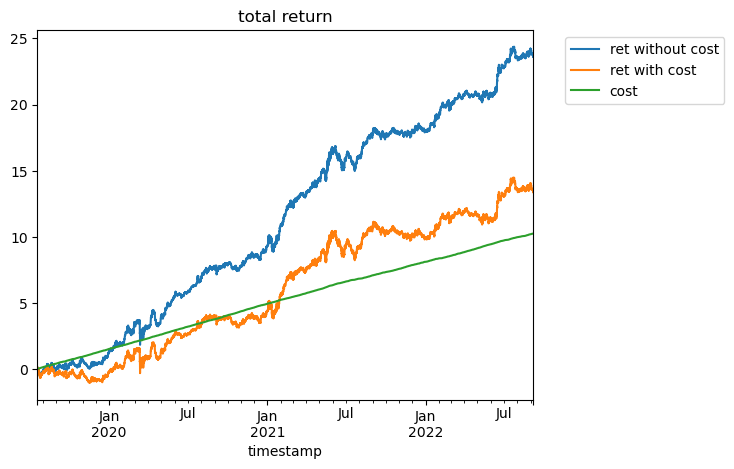

In [15]:
# df = pd.read_pickle('/tmp/df_horizon4_btc.pkl')
df = pd.read_pickle('/tmp/df_horizon4_eth.pkl')
# df = pd.read_pickle('/tmp/df_horizon4_bnb.pkl')
# df = pd.read_pickle('/tmp/df_horizon4_atom.pkl')

model = ExampleModelRank()

# cv
calc_position_cv(model, df)
visualize_result(df.dropna(), execution_cost=0.0004)

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/20220907_eth.xz', 'wb') as f:
    f.write(data)

timestamp                  symbol
2022-08-24 11:00:00+00:00  ETH       1.0
2022-08-24 12:00:00+00:00  ETH       1.0
2022-08-24 13:00:00+00:00  ETH      -1.0
2022-08-24 14:00:00+00:00  ETH      -1.0
2022-08-24 15:00:00+00:00  ETH       1.0
                                    ... 
2022-09-07 07:00:00+00:00  ETH      -1.0
2022-09-07 08:00:00+00:00  ETH      -1.0
2022-09-07 09:00:00+00:00  ETH      -1.0
2022-09-07 10:00:00+00:00  ETH      -1.0
2022-09-07 11:00:00+00:00  ETH      -1.0
Name: position, Length: 337, dtype: float64
['ETH']
test shift predict


,,position1,position2,position3
timestamp,symbol,,,
2022-08-24 12:00:00+00:00,ETH,1.0,1.0,1.0
2022-08-24 13:00:00+00:00,ETH,-1.0,-1.0,-1.0
2022-08-24 14:00:00+00:00,ETH,-1.0,-1.0,-1.0
2022-08-24 15:00:00+00:00,ETH,1.0,1.0,1.0
2022-08-24 16:00:00+00:00,ETH,1.0,1.0,1.0
...,...,...,...,...
2022-09-07 06:00:00+00:00,ETH,-1.0,-1.0,-1.0
2022-09-07 07:00:00+00:00,ETH,-1.0,-1.0,-1.0
2022-09-07 08:00:00+00:00,ETH,-1.0,-1.0,-1.0


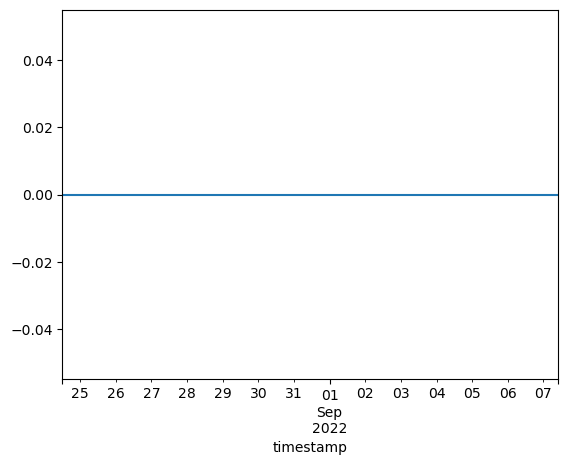

ETH (335, 4)


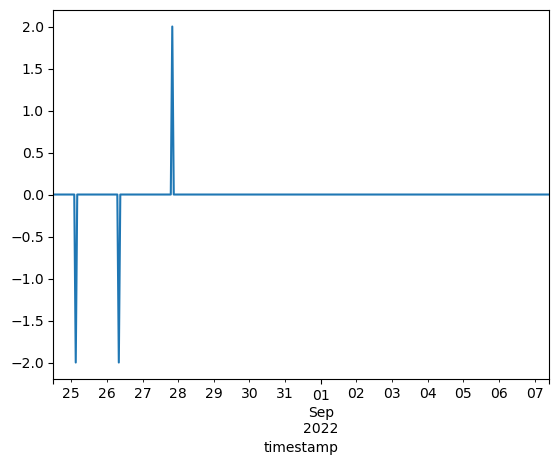

ETH (337, 3)


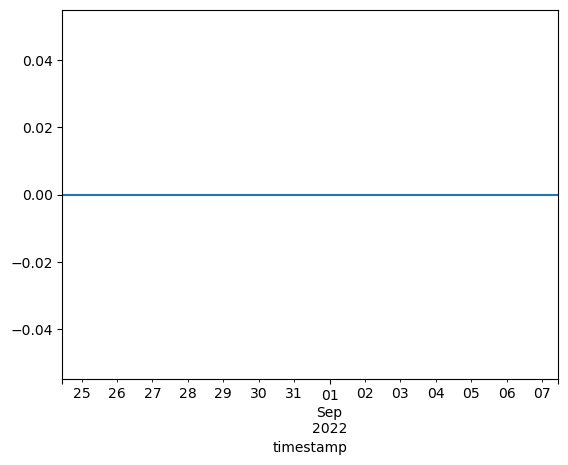

In [16]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/20220907_eth.xz')
df = pd.read_pickle('/tmp/df_horizon4_eth.pkl')
df = df[['op', 'hi', 'lo', 'cl']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

def _calc_features(df):        
    df = df.copy()

    for i in [2, 4, 8, 24, 48, 72]:
        df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)
    for i in [2, 4, 8, 24, 48, 72]:
        df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))

    for col in get_feature_columns(df):
        df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5

    return df

df_features1 = _calc_features(df)
df_features3 = _calc_features(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()

df_test2 = pd.concat([
    df_features1['feature_rsi_72'].rename('feature1'),
    df_features3['feature_rsi_72'].rename('feature3'),
    # df_features1['feature_momentum_72'].rename('feature1'),
    # df_features3['feature_momentum_72'].rename('feature3'),
], axis=1)

for symbol, df_symbol in df_test2.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['feature3'] - df_symbol['feature1']).plot()
plt.show()